# Sign Language Recognition using CNN (PyTorch + Intel Arc GPU)

โปรเจกต์นี้สร้าง AI Model สำหรับจำแนก Sign Language โดยใช้ Sign Language MNIST Dataset



## 1. Setup และตรวจสอบ Intel Arc GPU

In [10]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, confusion_matrix
import kagglehub

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# ตรวจสอบ Intel Arc GPU (XPU)
if hasattr(torch, 'xpu'):
    print(f"\n✅ XPU (Intel GPU) available: {torch.xpu.is_available()}")
    if torch.xpu.is_available():
        print(f"   Device count: {torch.xpu.device_count()}")
        for i in range(torch.xpu.device_count()):
            print(f"   Device {i}: {torch.xpu.get_device_name(i)}")
        device = torch.device('xpu:0')
        print(f"\n🚀 Using device: {device} ({torch.xpu.get_device_name(0)})")
    else:
        device = torch.device('cpu')
        print(f"\n⚠️  XPU not available, using CPU")
else:
    device = torch.device('cpu')
    print(f"\n⚠️  XPU module not found, using CPU")

PyTorch version: 2.8.0+xpu
CUDA available: False

✅ XPU (Intel GPU) available: True
   Device count: 1
   Device 0: Intel(R) Arc(TM) A530M Graphics

🚀 Using device: xpu:0 (Intel(R) Arc(TM) A530M Graphics)


## 2. โหลดและเตรียมข้อมูล

In [11]:
# Download dataset from Kaggle
print("Downloading Sign Language MNIST dataset...")
path = kagglehub.dataset_download("datamunge/sign-language-mnist")
print(f"Path to dataset files: {path}")

# โหลดข้อมูล
train_df = pd.read_csv(os.path.join(path, 'sign_mnist_train.csv'))
test_df = pd.read_csv(os.path.join(path, 'sign_mnist_test.csv'))

print(f"\nTraining data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Path to dataset files: C:\Users\jurin\.cache\kagglehub\datasets\datamunge\sign-language-mnist\versions\1

Training data shape: (27455, 785)
Testing data shape: (7172, 785)


In [ ]:
# ตรวจสอบ labels ที่มีจริงใน dataset
print("Checking actual dataset labels...")
unique_labels = sorted(test_df.iloc[:, 0].unique())
print(f"Unique labels in dataset: {unique_labels}")
print(f"Number of unique labels: {len(unique_labels)}")

# สร้าง label mapping ที่ถูกต้อง
# Dataset มี 24 classes: A-I, K-Y (ไม่มี J และ Z)
# Labels ที่มีจริง: 0-8 (A-I), 10-24 (K-Y)
label_map = {}

# A-I (labels 0-8)
for i in range(9):
    label_map[i] = chr(65 + i)  # A, B, C, D, E, F, G, H, I

# K-Y (labels 10-24) - ไม่มี label 9 (J)
for i in range(10, 25):
    label_map[i] = chr(65 + i)  # K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y

print("\n✅ Corrected Label Mapping:")
print(label_map)

# ตรวจสอบว่า mapping ถูกต้อง
print(f"\nAvailable letters: {sorted(label_map.values())}")
print(f"Total letters: {len(label_map)}")

# เตือนว่าไม่มี J และ Z
missing_letters = []
for letter in ['J', 'Z']:
    if letter not in label_map.values():
        missing_letters.append(letter)

if missing_letters:
    print(f"⚠️  Missing letters (as expected): {missing_letters}")
    print("   J: Requires motion gestures (not in static dataset)")
    print("   Z: Not included in Sign Language MNIST dataset")

Checking actual dataset labels...
Unique labels in dataset: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24)]
Number of unique labels: 24

✅ Corrected Label Mapping:
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'}

Available letters: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
Total letters: 24
⚠️  Missing letters (as expected): ['J', 'Z']
   J: Requires motion gestures (not in static dataset)
   Z: Not included in Sign Language MNIST dataset


In [13]:
# PyTorch Dataset class
class SignLanguageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get label
        label = self.data.iloc[idx, 0]
        
        # Get pixels and reshape to 28x28
        pixels = self.data.iloc[idx, 1:].values.astype(np.float32)
        image = pixels.reshape(28, 28)
        
        # Normalize to [0, 1]
        image = image / 255.0
        
        # Add channel dimension (1, 28, 28)
        image = np.expand_dims(image, axis=0)
        
        # Convert to tensor
        image = torch.from_numpy(image)
        
        # Apply transforms if any
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("✅ Dataset class created")

✅ Dataset class created


In [14]:
# Data augmentation สำหรับ training
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
])

# สร้าง datasets
train_dataset = SignLanguageDataset(train_df, transform=train_transform)
test_dataset = SignLanguageDataset(test_df, transform=None)

# แบ่ง train เป็น train + validation (80-20)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Training set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")

# สร้าง DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"\n✅ DataLoaders created (batch size: {batch_size})")

Training set: 21964 samples
Validation set: 5491 samples
Test set: 7172 samples

✅ DataLoaders created (batch size: 128)


## 3. สร้าง CNN Model (PyTorch)

In [15]:
# CNN Model Architecture
class SignLanguageCNN(nn.Module):
    def __init__(self, num_classes=24):  # ✅ แก้ไขเป็น 24 classes (ตรงกับ dataset จริง)
        super(SignLanguageCNN, self).__init__()
        
        # Conv Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        # Conv Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        # Conv Block 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.25)
        
        # Dense Layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.bn7 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn8 = nn.BatchNorm1d(128)
        self.dropout5 = nn.Dropout(0.5)
        
        # Output Layer - ✅ ตอนนี้จะเป็น 24 classes
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Conv Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Conv Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Conv Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Dense Layers
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        
        x = F.relu(self.bn8(self.fc2(x)))
        x = self.dropout5(x)
        
        # Output
        x = self.fc3(x)
        
        return x

# สร้าง model และย้ายไป Intel Arc GPU
# ✅ ตอนนี้ใช้ 24 classes ที่ถูกต้อง
model = SignLanguageCNN(num_classes=24).to(device)

# แสดงจำนวน parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✅ Model created and moved to {device}")
print(f"   Classes: 24 (correct - matches dataset)")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"\nModel architecture:")
print(model)


✅ Model created and moved to xpu:0
   Classes: 24 (correct - matches dataset)
   Total parameters: 619,256
   Trainable parameters: 619,256

Model architecture:
SignLanguageCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kern

## 4. Train Model บน Intel Arc GPU

In [16]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        # Move data to device (Intel Arc GPU)
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

print("✅ Training functions defined")

✅ Training functions defined


In [17]:
# Setup training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training parameters
num_epochs = 17
best_val_acc = 0.0
patience = 10
patience_counter = 0

# History
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print(f"\n🚀 Starting training on {device}...")
print(f"Epochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print(f"Optimizer: Adam (lr=0.001)")
print("="*60)


🚀 Starting training on xpu:0...
Epochs: 17
Batch size: 128
Optimizer: Adam (lr=0.001)


In [18]:
# Training loop
import time

for epoch in range(num_epochs):
    start_time = time.time()
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Elapsed time
    elapsed = time.time() - start_time
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}] ({elapsed:.1f}s) - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save best model - ✅ ใช้ชื่อไฟล์ใหม่เพื่อแยกจากโมเดลเก่า
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_sign_language_model_pytorch_corrected_24classes.pth')
        print(f"  ✅ Model saved (Val Acc: {val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\n⚠️ Early stopping at epoch {epoch+1}")
        break

print("\n✅ Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print("📁 Model saved as: best_sign_language_model_pytorch_corrected_24classes.pth")

Epoch [1/17] (68.2s) - Train Loss: 2.7471, Train Acc: 17.71% - Val Loss: 1.8307, Val Acc: 52.39%
  ✅ Model saved (Val Acc: 52.39%)
Epoch [2/17] (74.4s) - Train Loss: 1.5676, Train Acc: 54.33% - Val Loss: 0.7986, Val Acc: 81.50%
  ✅ Model saved (Val Acc: 81.50%)
Epoch [3/17] (21.0s) - Train Loss: 0.9048, Train Acc: 75.67% - Val Loss: 0.4177, Val Acc: 91.88%
  ✅ Model saved (Val Acc: 91.88%)
Epoch [4/17] (20.6s) - Train Loss: 0.5971, Train Acc: 85.12% - Val Loss: 0.2869, Val Acc: 94.28%
  ✅ Model saved (Val Acc: 94.28%)
Epoch [5/17] (20.5s) - Train Loss: 0.4524, Train Acc: 89.41% - Val Loss: 0.2257, Val Acc: 95.36%
  ✅ Model saved (Val Acc: 95.36%)
Epoch [6/17] (43.7s) - Train Loss: 0.3741, Train Acc: 91.31% - Val Loss: 0.2160, Val Acc: 95.48%
  ✅ Model saved (Val Acc: 95.48%)
Epoch [7/17] (39.3s) - Train Loss: 0.3267, Train Acc: 92.85% - Val Loss: 0.2009, Val Acc: 95.67%
  ✅ Model saved (Val Acc: 95.67%)
Epoch [8/17] (90.0s) - Train Loss: 0.3060, Train Acc: 93.23% - Val Loss: 0.2087, Va

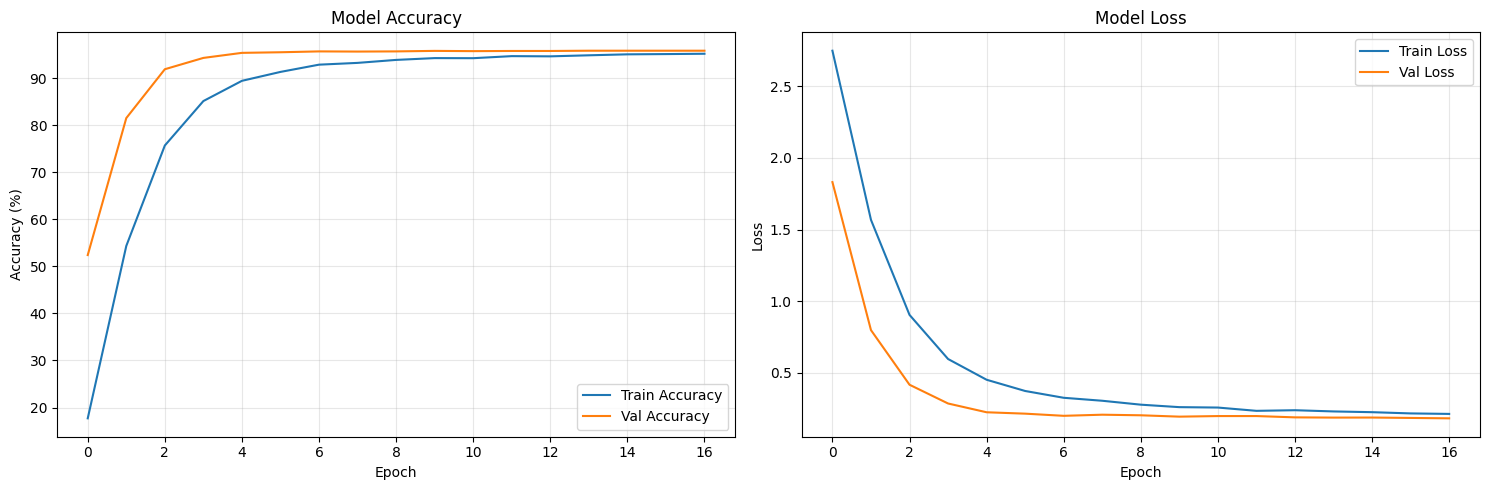

In [19]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
ax1.plot(history['train_acc'], label='Train Accuracy')
ax1.plot(history['val_acc'], label='Val Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(history['train_loss'], label='Train Loss')
ax2.plot(history['val_loss'], label='Val Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. ประเมินผลและทดสอบ

In [20]:
# Load best model
model.load_state_dict(torch.load('best_sign_language_model_pytorch_corrected_24classes.pth'))
model.eval()

# Test evaluation
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"\n📊 Test Results (Corrected 24-class Model):")
print(f"   Test Accuracy: {test_acc:.2f}%")
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Model correctly uses {len(label_map)} classes")


📊 Test Results (Corrected 24-class Model):
   Test Accuracy: 95.37%
   Test Loss: 0.2007
   Model correctly uses 24 classes


In [21]:
# Get predictions for classification report
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification Report
available_labels = sorted(np.unique(all_labels))
target_names = [label_map[i] for i in available_labels]

print("\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, labels=available_labels, target_names=target_names))


📋 Classification Report:
              precision    recall  f1-score   support

           A       0.57      1.00      0.72       331
           B       1.00      1.00      1.00       432
           C       1.00      1.00      1.00       310
           D       1.00      1.00      1.00       245
           E       1.00      1.00      1.00       498
           F       1.00      1.00      1.00       247
           G       1.00      1.00      1.00       348
           H       1.00      1.00      1.00       436
           I       0.94      1.00      0.97       288
           K       1.00      1.00      1.00       331
           L       1.00      1.00      1.00       209
           M       1.00      1.00      1.00       394
           N       1.00      1.00      1.00       291
           O       1.00      1.00      1.00       246
           P       1.00      1.00      1.00       347
           Q       1.00      1.00      1.00       164
           R       1.00      1.00      1.00       144
 

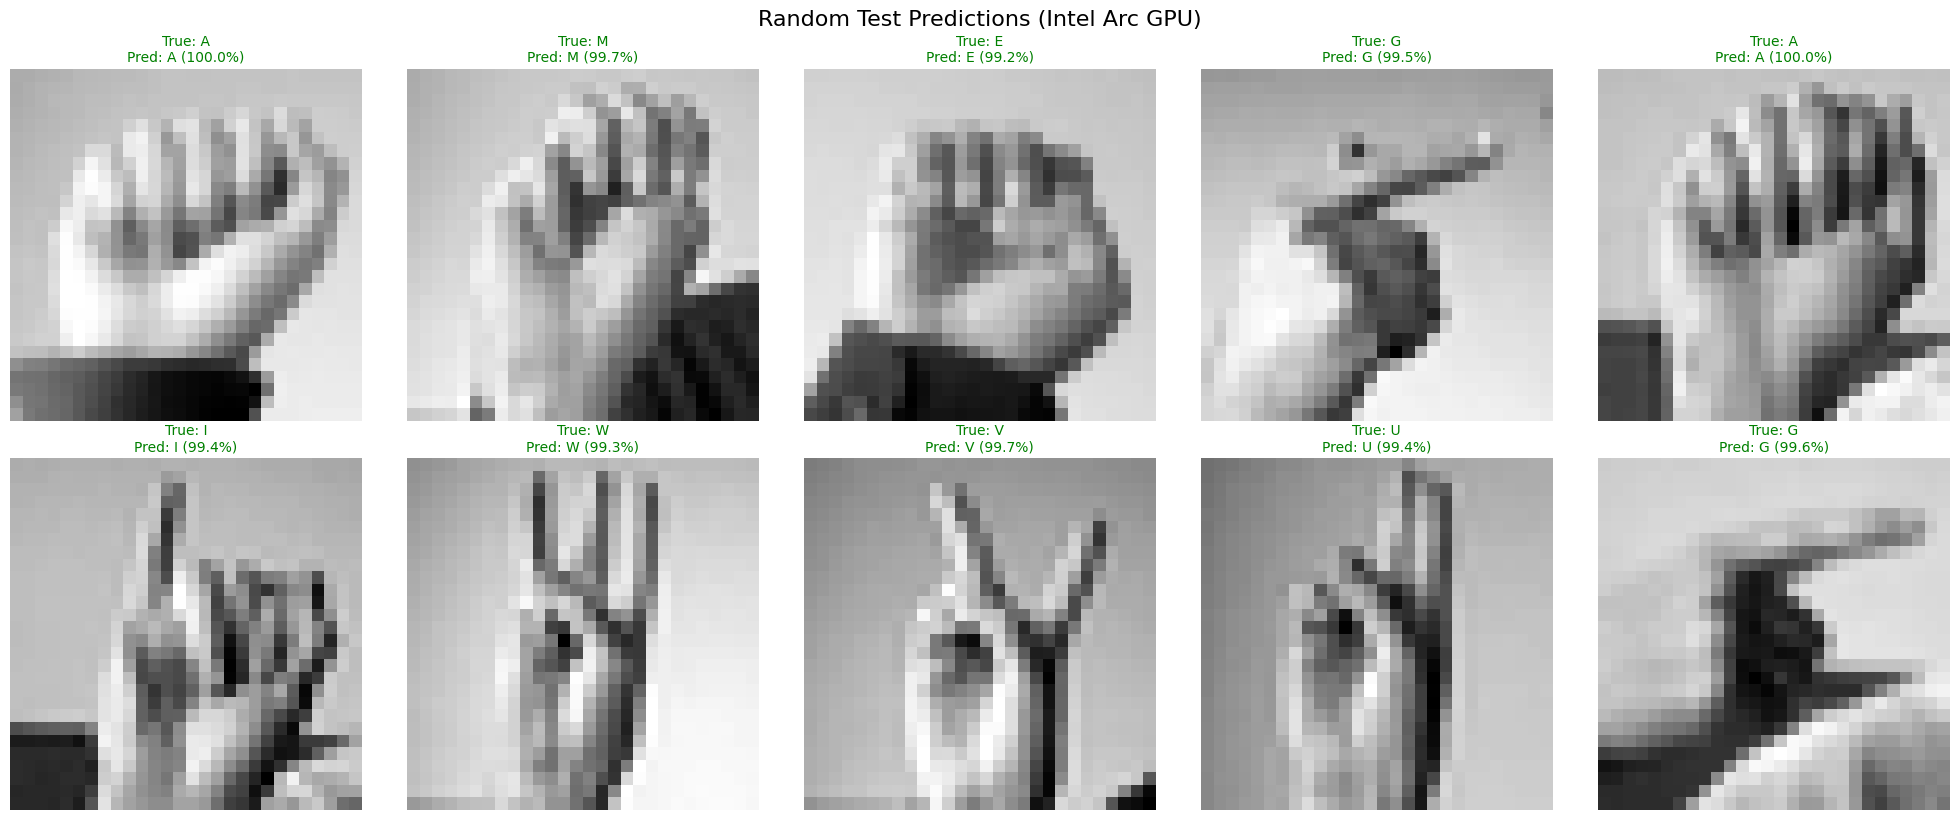

In [22]:
# ทดสอบด้วยภาพสุ่ม
def test_random_predictions(n_samples=10):
    model.eval()
    
    # สุ่มภาพ
    random_indices = np.random.choice(len(test_dataset), n_samples, replace=False)
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    with torch.no_grad():
        for idx, test_idx in enumerate(random_indices):
            image, true_label = test_dataset[test_idx]
            
            # Predict
            image_input = image.unsqueeze(0).to(device)
            output = model(image_input)
            _, pred_class = torch.max(output, 1)
            confidence = F.softmax(output, dim=1)[0][pred_class].item()
            
            pred_class = pred_class.item()
            
            # Display
            axes[idx].imshow(image.squeeze().cpu().numpy(), cmap='gray')
            
            title = f"True: {label_map[true_label]}\n"
            title += f"Pred: {label_map[pred_class]} ({confidence*100:.1f}%)"
            
            color = 'green' if pred_class == true_label else 'red'
            axes[idx].set_title(title, fontsize=10, color=color)
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Random Test Predictions (Intel Arc GPU)', y=1.02, fontsize=16)
    plt.show()

test_random_predictions(10)

In [23]:
# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_acc': best_val_acc,
    'history': history,
    'label_map': label_map,  # ✅ เพิ่ม label mapping ที่ถูกต้อง
    'num_classes': 24       # ✅ เพิ่มจำนวน classes
}, 'sign_language_model_pytorch_corrected_24classes_final.pth')

print("\n✅ Corrected Model saved successfully!")
print("   📁 Files created:")
print("      - best_sign_language_model_pytorch_corrected_24classes.pth (best weights)")
print("      - sign_language_model_pytorch_corrected_24classes_final.pth (complete checkpoint)")
print(f"\n🎯 Model Summary:")
print(f"   - Classes: 24 (correct)")
print(f"   - Available letters: A-I, K-Y") 
print(f"   - Missing letters: J (motion), Z (not in dataset)")
print(f"   - Best validation accuracy: {best_val_acc:.2f}%")


✅ Corrected Model saved successfully!
   📁 Files created:
      - best_sign_language_model_pytorch_corrected_24classes.pth (best weights)
      - sign_language_model_pytorch_corrected_24classes_final.pth (complete checkpoint)

🎯 Model Summary:
   - Classes: 24 (correct)
   - Available letters: A-I, K-Y
   - Missing letters: J (motion), Z (not in dataset)
   - Best validation accuracy: 95.81%
